# Adjusting currencies 

## Extracting the prices from Barcelona json file

In [1]:
import json
import pandas as pd
import os

#Open the madrid coworkings csv
path = '/workspaces/Coworking/src/results/Barcelona/Barcelona_coworking_spaces.json'

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df_barcelona_price = pd.json_normalize(data)

df_barcelona_price= df_barcelona_price[['price']]

In [2]:
import re

# Function to extract the price
def extract_price(text):
    if pd.isna(text):  # Handle missing values
        return None
    match = re.search(r'(\d+)', text)  # Extract the first number
    return int(match.group(1)) if match else None  # Convert to int if found

# Apply the function to the 'price' column
df_barcelona_price['price_cleaned'] = df_barcelona_price['price'].apply(extract_price)

# Display the results
print(df_barcelona_price[['price', 'price_cleaned']])

                                    price  price_cleaned
0    Private Office\n from € 1214\n/month         1214.0
1     Private Office\n from € 305\n/month          305.0
2                           1\n2\n3\n4\n5            1.0
3     Private Office\n from € 155\n/month          155.0
4     Private Office\n from € 345\n/month          345.0
..                                    ...            ...
182     Private Office \nPrice on request            NaN
183     Private Office \nPrice on request            NaN
184                1\n2\n3\n4\n5\n6\n7\n8            1.0
185     Private Office \nPrice on request            NaN
186     Private Office \nPrice on request            NaN

[187 rows x 2 columns]


## Extract the price from Madrid json file.

In [3]:
import json
import pandas as pd
import os

#Open the madrid coworkings csv
path = '/workspaces/Coworking/src/results/Madrid/Madrid_coworking_spaces.json'

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.json_normalize(data)

df_madrid_price= df[['price']]

In [4]:
import re

# Function to extract the price
def extract_price(text):
    if pd.isna(text):  # Handle missing values
        return None
    match = re.search(r'(\d+)', text)  # Extract the first number
    return int(match.group(1)) if match else None  # Convert to int if found

# Apply the function to the 'price' column
df_madrid_price['price_cleaned'] = df_madrid_price['price'].apply(extract_price)

# Display the results
print(df_madrid_price[['price', 'price_cleaned']])

                                   price  price_cleaned
0    Private Office\n from € 490\n/month          490.0
1    Private Office\n from € 189\n/month          189.0
2    Private Office\n from € 315\n/month          315.0
3    Private Office\n from € 980\n/month          980.0
4    Private Office\n from € 225\n/month          225.0
..                                   ...            ...
180    Private Office \nPrice on request            NaN
181    Private Office \nPrice on request            NaN
182    Private Office \nPrice on request            NaN
183    Private Office \nPrice on request            NaN
184                        1\n2\n3\n4\n5            1.0

[185 rows x 2 columns]


/tmp/ipykernel_4215/871941500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_madrid_price['price_cleaned'] = df_madrid_price['price'].apply(extract_price)


## Merge both prices dataframes.

In [5]:
import pandas as pd

# Concatenate both dataframes
df_euro = pd.concat([df_madrid_price, df_barcelona_price], ignore_index=True)

# Optionally, you can reset the index if needed
df_euro.reset_index(drop=True, inplace=True)

df_euro.head()

,price,price_cleaned
0,Private Office\n from € 490\n/month,490.0
1,Private Office\n from € 189\n/month,189.0
2,Private Office\n from € 315\n/month,315.0
3,Private Office\n from € 980\n/month,980.0
4,Private Office\n from € 225\n/month,225.0


In [6]:
df_euro.drop(columns='price', inplace=True)

df_euro.head()

,price_cleaned
0,490.0
1,189.0
2,315.0
3,980.0
4,225.0


### Transform NaN values with the median.

In [7]:
df_euro.isna().sum()

price_cleaned    27
dtype: int64

In [8]:
median_price = df_euro['price_cleaned'].median()
df_euro['price_cleaned'].fillna(median_price, inplace=True)

/tmp/ipykernel_4215/1063668431.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_euro['price_cleaned'].fillna(median_price, inplace=True)


In [9]:
df_euro.isna().sum()

price_cleaned    0
dtype: int64

## Convert Euro in USD and normalize

### Using ExchangeRate-API

In [10]:
import pandas as pd
import requests

# Define your API endpoint and your API key
api_key = "7352f0026f58a51e76be2471"  # Replace with your API key
api_url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/EUR"

# Fetch the EUR to USD conversion rate from the API
def get_eur_to_usd_rate():
    response = requests.get(api_url)
    data = response.json()
    
    # Check if the response is valid
    if data['result'] == 'success':
        return data['conversion_rates']['USD']
    else:
        raise Exception("Error fetching exchange rate from API")

# Convert EUR to USD
def convert_eur_to_usd(eur_price, conversion_rate):
    return eur_price * conversion_rate

# Fetch the conversion rate (EUR to USD)
conversion_rate = get_eur_to_usd_rate()

# Apply the conversion to the 'price' column
df_euro['price_usd'] = df_euro['price_cleaned'].apply(lambda x: convert_eur_to_usd(x, conversion_rate))

# Print the updated DataFrame
print(df_euro)


     price_cleaned  price_usd
0            490.0   555.6110
1            189.0   214.3071
2            315.0   357.1785
3            980.0  1111.2220
4            225.0   255.1275
..             ...        ...
367          250.0   283.4750
368          250.0   283.4750
369            1.0     1.1339
370          250.0   283.4750
371          250.0   283.4750

[372 rows x 2 columns]


In [11]:
df_euro.drop(columns='price_cleaned', inplace=True)

df_euro.head()

,price_usd
0,555.6110
1,214.3071
2,357.1785
3,1111.2220
4,255.1275


### The PPP factor of Spain is 1(LCU/Euro)(Local Currency Unit)

## Convert Yens in USD and use the PPP factor.

In [12]:
import json
import pandas as pd
import os

#Open the madrid coworkings csv
path = '/workspaces/Coworking/src/results/Tokyo/tokyo_coworking_spaces.json'

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.json_normalize(data)

df_tokyo_price= df[['price']]

In [13]:
import re

df_tokyo_price['price_cleaned'] = df_tokyo_price['price'].apply(extract_price)

# Display the results
print(df_tokyo_price[['price', 'price_cleaned']])

                                     price  price_cleaned
0    Private Office\n from ¥ 55500\n/month        55500.0
1    Private Office\n from ¥ 69900\n/month        69900.0
2    Private Office\n from ¥ 43000\n/month        43000.0
3    Private Office\n from ¥ 58500\n/month        58500.0
4    Private Office\n from ¥ 71900\n/month        71900.0
..                                     ...            ...
191      Private Office \nPrice on request            NaN
192                          1\n2\n3\n4\n5            1.0
193      Private Office \nPrice on request            NaN
194      Private Office \nPrice on request            NaN
195      Private Office \nPrice on request            NaN

[196 rows x 2 columns]


/tmp/ipykernel_4215/3197838495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price['price_cleaned'] = df_tokyo_price['price'].apply(extract_price)


In [14]:
df_tokyo_price.isna().sum()

price             0
price_cleaned    25
dtype: int64

In [15]:
median_price = df_tokyo_price['price_cleaned'].median()
df_tokyo_price['price_cleaned'].fillna(median_price, inplace=True)

/tmp/ipykernel_4215/616912941.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tokyo_price['price_cleaned'].fillna(median_price, inplace=True)
/tmp/ipykernel_4215/616912941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price['price_cleaned'].fillna(median_price, inplace=True)


In [16]:
df_tokyo_price.drop(columns='price', inplace=True)

/tmp/ipykernel_4215/1139496757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price.drop(columns='price', inplace=True)


In [17]:
import pandas as pd
import requests

# Define your API endpoint and your API key
api_key = "7352f0026f58a51e76be2471"  # Replace with your API key
api_url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/EUR"

# Fetch the EUR to USD conversion rate from the API
def get_eur_to_usd_rate():
    response = requests.get(api_url)
    data = response.json()
    
    # Check if the response is valid
    if data['result'] == 'success':
        return data['conversion_rates']['USD']
    else:
        raise Exception("Error fetching exchange rate from API")

# Convert EUR to USD
def convert_eur_to_usd(eur_price, conversion_rate):
    return eur_price * conversion_rate

# Fetch the conversion rate (EUR to USD)
conversion_rate = get_eur_to_usd_rate()

# Apply the conversion to the 'price' column
df_tokyo_price['price_usd'] = df_tokyo_price['price_cleaned'].apply(lambda x: convert_eur_to_usd(x, conversion_rate))

# Print the updated DataFrame
print(df_tokyo_price)


     price_cleaned   price_usd
0          55500.0  62931.4500
1          69900.0  79259.6100
2          43000.0  48757.7000
3          58500.0  66333.1500
4          71900.0  81527.4100
..             ...         ...
191        35000.0  39686.5000
192            1.0      1.1339
193        35000.0  39686.5000
194        35000.0  39686.5000
195        35000.0  39686.5000

[196 rows x 2 columns]


/tmp/ipykernel_4215/4015434545.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price['price_usd'] = df_tokyo_price['price_cleaned'].apply(lambda x: convert_eur_to_usd(x, conversion_rate))


In [18]:
df_tokyo_price.drop(columns='price_cleaned', inplace=True)

/tmp/ipykernel_4215/1048160013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price.drop(columns='price_cleaned', inplace=True)


### The PPP of Japan is 95(LSU/USD)

In [19]:
df_tokyo_price['price_usd'] = df_tokyo_price['price_usd']*95

df_tokyo_price.head()

/tmp/ipykernel_4215/1995806028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokyo_price['price_usd'] = df_tokyo_price['price_usd']*95


,price_usd
0,5978487.75
1,7529662.95
2,4631981.50
3,6301649.25
4,7745103.95


## Convert Real into USD and use the PPP factor.

In [20]:
import json
import pandas as pd
import os

#Open Sao Paulo json
path = '/workspaces/Coworking/src/results/Sao Paulo/sp_coworking_spaces.json'

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.json_normalize(data)

df_brazil_price= df[['price']]

In [21]:
import re

# Function to extract the price
def extract_price(text):
    if pd.isna(text):  # Handle missing values
        return None
    match = re.search(r'(\d+)', text)  # Extract the first number
    return int(match.group(1)) if match else None  # Convert to int if found

# Apply the function to the 'price' column
df_brazil_price['price_cleaned'] = df_brazil_price['price'].apply(extract_price)

# Display the results
print(df_brazil_price[['price', 'price_cleaned']])

                                     price  price_cleaned
0    Private Office\n from R$ 1385\n/month         1385.0
1    Private Office\n from R$ 1015\n/month         1015.0
2    Private Office\n from R$ 1565\n/month         1565.0
3    Private Office\n from R$ 1389\n/month         1389.0
4    Private Office\n from R$ 1899\n/month         1899.0
..                                     ...            ...
133      Private Office \nPrice on request            NaN
134      Private Office \nPrice on request            NaN
135                       1\n2\n3\n4\n5\n6            1.0
136      Private Office \nPrice on request            NaN
137      Private Office \nPrice on request            NaN

[138 rows x 2 columns]


/tmp/ipykernel_4215/1699147551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brazil_price['price_cleaned'] = df_brazil_price['price'].apply(extract_price)


In [22]:
df_brazil_price.isna().sum()

price             0
price_cleaned    32
dtype: int64

In [23]:
median_price = df_brazil_price['price_cleaned'].median()
df_brazil_price['price_cleaned'].fillna(median_price, inplace=True)

/tmp/ipykernel_4215/4224878642.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_brazil_price['price_cleaned'].fillna(median_price, inplace=True)
/tmp/ipykernel_4215/4224878642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brazil_price['price_cleaned'].fillna(median_price, inplace=True)


In [24]:
df_brazil_price = df_brazil_price[df_brazil_price['price_cleaned'] != 1]


In [25]:
df_brazil_price.drop(columns='price', inplace=True)

## Load New York prices.

In [26]:
import json
import pandas as pd
import os

#Open New York json
path = '/workspaces/Coworking/src/results/New York/New_York_coworking_spaces.json'

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.json_normalize(data)

df_newyork_price= df[['price']]

In [27]:
import re

# Function to extract the price
def extract_price(text):
    if pd.isna(text):  # Handle missing values
        return None
    match = re.search(r'(\d+)', text)  # Extract the first number
    return int(match.group(1)) if match else None  # Convert to int if found

# Apply the function to create a new column 'price_cleaned'
df_newyork_price['price_cleaned'] = df_newyork_price['price'].apply(extract_price)

# Display the results
print(df_newyork_price[['price', 'price_cleaned']].head())

/tmp/ipykernel_4215/1387685678.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_newyork_price['price_cleaned'] = df_newyork_price['price'].apply(extract_price)


                                               price  price_cleaned
0                                    Price not found            NaN
1  Coworking Space\nfrom \n$ 420\n/month\nGET QUO...          420.0
2                                    Price not found            NaN
3                Private Office\n from $ 615\n/month          615.0
4               Private Office\n from $ 3875\n/month         3875.0


In [28]:
df_newyork_price.isna().sum()

price              0
price_cleaned    230
dtype: int64

In [29]:
df_newyork_price.dropna()

,price,price_cleaned
1,Coworking Space\nfrom \n$ 420\n/month\nGET QUO...,420.0
3,Private Office\n from $ 615\n/month,615.0
4,Private Office\n from $ 3875\n/month,3875.0
5,Private Office\n from $ 1350\n/month,1350.0
6,Private Office\n from $ 3200\n/month,3200.0
...,...,...
356,Private Office \nfrom $ 1110\n/month,1110.0
361,1\n2\n3\n4\n5\n6,1.0
372,1\n2\n3\n4\n5,1.0
386,1\n2\n3\n4\n5\n6,1.0


In [30]:
df_newyork_price.drop(columns='price', inplace=True)

/tmp/ipykernel_4215/2059561520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_newyork_price.drop(columns='price', inplace=True)


In [31]:
df_newyork_price.describe()

,price_cleaned
count,278.000000
mean,955.316547
std,1577.473914
min,1.000000
25%,371.000000
50%,700.000000
75%,1000.000000
max,19500.000000


## Merge all the prices.

In [32]:
import pandas as pd

df_prices = pd.concat([df_euro, df_tokyo_price, df_brazil_price, df_newyork_price]).stack().reset_index(drop=True).to_frame(name='price')

df_prices.head()

,price
0,555.6110
1,214.3071
2,357.1785
3,1111.2220
4,255.1275


In [33]:
df_prices.shape

(971, 1)

In [34]:
df_prices.describe()

,price
count,9.710000e+02
mean,1.275921e+06
std,9.893945e+06
min,1.000000e+00
25%,2.602301e+02
50%,6.236450e+02
75%,1.705000e+03
max,2.973086e+08


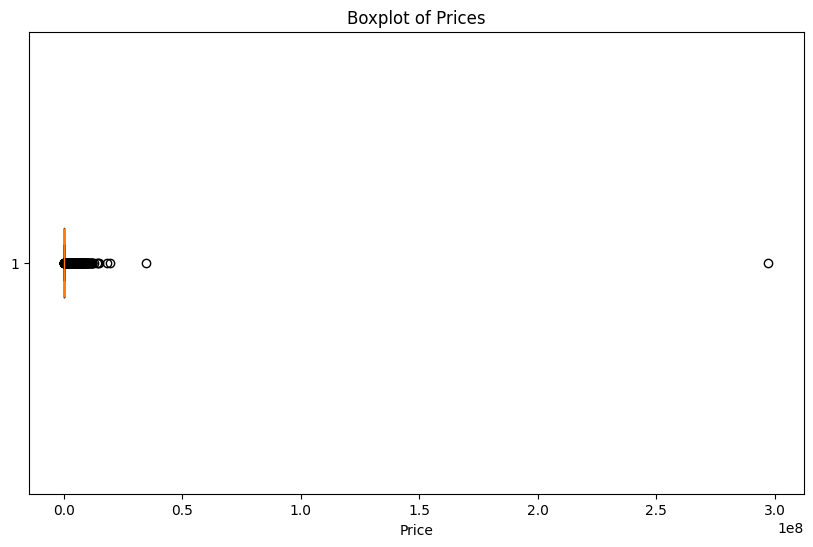

In [35]:
import matplotlib.pyplot as plt

# Create a boxplot to visualize outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df_prices['price'], vert=False)
plt.title('Boxplot of Prices')
plt.xlabel('Price')
plt.show()

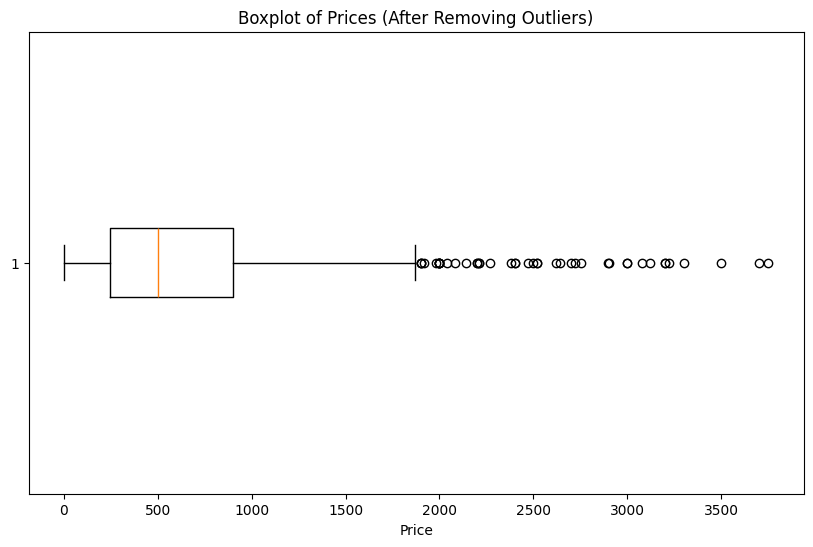

Original number of records: 971
Number of records after removing outliers: 779


Bad pipe message: %s [b'u; Linux x86_64; rv:137.0) Gecko/20100101 Firefox/137.0\r\nAccept: text/html,application/xhtml+xml,application/']
Bad pipe message: %s [b'l;q=0.9,*/*;q=0.8\r\nAccept-Language: en-US,en;q=0.5\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nDNT: 1\r\nSec-GPC: 1\r\nConne', b'ion: keep-alive\r\nCookie: ajs_anonymous_id=066901b2-045c-4e8e-919a-35dee6f78dd1\r\nUpgrade-Insecure-R']
Bad pipe message: %s [b'u; Linux x86_64; rv:137.0) Gecko/20100101 Firefox/137.0\r\nAccept: text/html,application/xhtml+xml,application/']
Bad pipe message: %s [b'l;q=0.9,*/*;q=0.8\r\nAccept-Language: en-US,en;q=0.5\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nDNT: 1\r\nSec-GPC: 1\r\nConne', b'ion: keep-alive\r\nCookie: ajs_anonymous_id=066901b2-045c-4e8e-919a-35dee6f78dd1\r\nUpgrade-Insecure-R']


In [39]:
# Calculate Q1, Q3, and IQR
Q1 = df_prices['price'].quantile(0.25)
Q3 = df_prices['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_prices_clean = df_prices[(df_prices['price'] >= lower_bound) & (df_prices['price'] <= upper_bound)]

# Create a new boxplot to visualize the cleaned data
plt.figure(figsize=(10, 6))
plt.boxplot(df_prices_clean['price'], vert=False)
plt.title('Boxplot of Prices (After Removing Outliers)')
plt.xlabel('Price')
plt.show()

print(f"Original number of records: {len(df_prices)}")
print(f"Number of records after removing outliers: {len(df_prices_clean)}")

In [36]:
df_one = df_prices[df_prices['price']==1]

print(df_one.shape)

(33, 1)


In [37]:
import pandas as pd

# Calculate median (excluding 1)
median_price = df_prices[df_prices['price'] != 1]['price'].median()

# Replace 1 with median
df_prices['price'] = df_prices['price'].replace(1, median_price)

print(df_prices)

         price
0     555.6110
1     214.3071
2     357.1785
3    1111.2220
4     255.1275
..         ...
966  1110.0000
967   666.0000
968   666.0000
969   666.0000
970   666.0000

[971 rows x 1 columns]


In [38]:
import pandas as pd

df_prices.to_json('/workspaces/Coworking/src/results/Cleaned_Prices.json', orient='records', indent=4)